# Simulation of the Multi-Server Queue

- Customer interarrival times are exponentially distributed with mean 0.2 minutes
- Service times are also exponentially distributed
    - We start with two servers, one with mean service time 0.8 minutes and the other 0.9 minutes 
    - We have the option to add servers with mean service time 1 minute
- One shift lasts 100 minutes, and the system resets after each shift

### Optimize Profit
- It costs 150 dollars per shift to operate each server
- We collect 5 dollars per customer in exchange for our service
* How many servers should we add in order to maximize profit?

In [1]:
import random
import math
import sys
from scipy import stats
from numpy import prod
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Initialization subroutines:

def initSimData(endTime = 100, meanInterarrival = 0.2, meanService = [0.8, 0.9], 
                servicePrice = 5, operatingCost = 150):
    # meanInterarrival: The expected time between arrivals (for sampling the exp dist)
    # meanService: A LIST of expected service times for each server
        # eg, for a two server queue with mean service times 0.8 and 0.9, meanService = [0.8, 0.9]
        # Note: order IS important bc the customer "prefers" servers with lower index (see findEmptyServer)
    #servicePrice: revenue collected for each service completion
    #operatingCost: cost per shift to operate one server
    numServers = len(meanService)
    time = 0
    inQueue = 0
    inServer = [0 for server in range(numServers)]
    return (time, inServer, inQueue, endTime, meanInterarrival, meanService, numServers, servicePrice, operatingCost)

def initMetrics():
    numArrivals = 0 #number of arrivals
    numDepartures = 0 #number of customers served
    totalQueueTime = 0 # total time spent in line by arriving customers
    totalSysTime = 0 # total time spent in the system by arriving customers
    s1BusyTime = 0 # total time s1 is busy
    allBusyTime = 0 # total time all servers are busy
    return (numArrivals, numDepartures, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime)

# Functionality of the future event list:

def addEvent(eventType, eventTime): #add an arrival/departure/end event to the future event list (fel)
    global fel
    event = (eventType, eventTime)
    fel.append(event)

def deleteEvent(index): #delete an event from the future event list (after the event logic is executed)
    global fel
    fel.pop(index)
    
def findNextEvent(): #find the event in the fel with the earliest time and return its index
    global fel
    earliestTime = 1e30
    earliestIndex = -1
    for i in range(len(fel)):
        event = fel[i]
        eventTime = event[1]
        if eventTime < earliestTime:
            earliestTime = eventTime
            earliestIndex = i
    return earliestIndex

# Other subroutines:

def findEmptyServer(): #returns the smallest index i: inServer[i] = 0 (index of first empty server)
    global inServer
    for serverIndex in range(numServers):
        if inServer[serverIndex] == 0:
            return serverIndex
    print("Error: no empty servers")
    sys.exit(2)

def findDepartingServer(eventType): #returns the index of the server from which the customer departed
    return int(eventType[1:])

def getInSystem(): #returns the number of customers in the system right now
    global inQueue, inServer
    n = inQueue + sum(inServer)
    return n

# Random sampling:

def generateInterarrival(): #generate an interarrival time from the exponential distribution
    global meanInterarrival
    sample = random.expovariate(1/meanInterarrival)
    return sample

def generateService(serverIndex): #generate a service time from the exponential distribution
    global meanService #list of mean service times for each server
    meanServerTime = meanService[serverIndex] #finds the mean ST of the relevant server in the meanService list
    sample = random.expovariate(1/meanServerTime) #generates a sample from the exp dist with the correct mean
    return sample

# Event handling logic and metric calculation:

def handleArrival(eventTime):
    global inQueue, inServer, time, numArrivals, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime
    
    #increment the variables used to calculate the metrics
    dTime = eventTime - time #time since the last event
    numArrivals += 1 #increment the arrival count
    s1BusyTime += inServer[0]*dTime #if s1 is busy, add the time since the last event
    allBusyTime += prod(inServer)*dTime #if all servers are busy, add the time since the last event
    totalSysTime += getInSystem()*dTime #add the time spent by all customers in the system since the last event
    totalQueueTime += inQueue*dTime #add the cumulative time spent by all in queue since last event
    
    #sample IA time and schedule next arrival event
    ia = generateInterarrival()
    addEvent("a", eventTime + ia)
    
    #direct the arrival to the correct server or queue
    if getInSystem() >= numServers:
        inQueue += 1
    else:
        serverIndex = findEmptyServer()
        inServer[serverIndex] = 1
        st = generateService(serverIndex)
        addEvent("d"+str(serverIndex), eventTime + st)
    time = eventTime
                
def handleDeparture(eventTime, serverIndex):
    global inQueue, inServer, time, numDepartures, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime
    
    #metrics:
    dTime = eventTime - time #time since the last event
    numDepartures += 1
    totalSysTime += getInSystem()*dTime #add the cumulative time spent by all customers since the last event
    totalQueueTime += inQueue*dTime #add the cumulative time spent by all in queue since last event
    s1BusyTime += inServer[0]*dTime #if s1 is busy, add the time since the last event
    allBusyTime += prod(inServer)*dTime #if both s1 and s2 busy, add the time since the last event
    
    #If there are customers waiting, the next in line goes immediately to the open server
    if inQueue > 0:
        inQueue -= 1
        st = generateService(serverIndex)
        addEvent("d"+str(serverIndex), eventTime + st)
    
    #if the queue is empty, the relevant server is no longer busy
    else:
        inServer[serverIndex] = 0
    time = eventTime
    
def handleEnd(eventTime):
    global inQueue, inServer, time, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime
    
    #metrics:
    dTime = eventTime - time #time since the last event
    totalSysTime += getInSystem()*dTime #add the cumulative time spent by all customers since the last event
    totalQueueTime += inQueue*dTime #add the cumulative time spent by all in queue since last event
    s1BusyTime += inServer[0]*dTime #if s1 is busy, add the time since the last event
    allBusyTime += prod(inServer)*dTime #if all servers are busy, add the time since the last event
    time = eventTime #update time. Sim loop will terminate since eventType != "e" is False

def initMetricsDict(keys):
    metrics = dict()
    for key in keys:
        metrics[key] = list()
    return metrics

def handleMetrics(): #calculate the metrics and append the results to the correct dictionary value
    global metrics, time, numServers, numArrivals, servicePrice, operatingCost
    global numDepartures, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime
    metrics["Arrivals"].append( numArrivals )
    metrics["Departures"].append( numDepartures )
    metrics["Avg time in queue"].append( totalQueueTime/numArrivals )
    metrics["Avg queue length"].append( totalQueueTime/time )
    metrics["Avg time in system"].append( totalSysTime/numArrivals )
    metrics["Avg customers in system"].append( totalSysTime/time )  
    metrics["Server 1 busy %"].append( s1BusyTime/time ) 
    metrics["All servers busy %"].append( allBusyTime/time )
    
    metrics["Revenue"].append(numDepartures*servicePrice)
    metrics["Cost"].append(operatingCost*numServers)
    metrics["Profit"].append( numDepartures*servicePrice - operatingCost*numServers )


def printConfidenceIntervals(keys): 
    #PRINTS 95% confidence intervals for each key
    #RETURNS a tuple of dictionaries containing (metric avgs, metric errors)
        # where errors are the statistical uncertainty
    
    global metrics, reps, servers
    #Z = scipy.stats.norm.ppf(.975)
    Z = 1.96
    metrics_avg = {}
    metrics_stdev = {}
    metrics_err = {}
    metrics_CI = {}
    print(len(servers) - 2,"extra servers:")
    for key in keys:

        #sample mean of each metric
        metrics_avg[key] = sum(metrics[key])/reps

        #sample stdev of each metric
        squares = 0
        for i in range(reps):
            squares += (metrics_avg[key] - metrics[key][i])**2
        metrics_stdev[key] =  math.sqrt( squares / reps )

        #95% CI on the expected value of each metric: CI = X +- Z*stdev/sqrt(reps)
        metrics_err[key] = Z * metrics_stdev[key] / math.sqrt(reps)
        metrics_CI[key] = ( metrics_avg[key] - metrics_err[key] , metrics_avg[key] + metrics_err[key])
    
        print(key + ":", metrics_CI[key])
    print("")
    return (metrics_avg, metrics_err)

In [3]:
#Determine the optimal number of servers to add

profits = list() #estimated expected profit indexed by the number of servers added
pErrors = list() #statistical uncertainty in profits at the 95% confidence level
revenues = list()
busyPercents = list()

servers = [0.8, 0.9] #starting point

while len(servers) < 12:

    keys = ["Arrivals", "Departures", "Avg time in queue", "Avg queue length",
            "Avg time in system", "Avg customers in system", "Server 1 busy %", 
            "All servers busy %", "Revenue", "Cost", "Profit" ]
    metrics = initMetricsDict(keys) #create the dictionary to keep track of the above metrics
    
    reps = 100 #100 reps takes ~10s 
    for r in range(reps): #Main simulation loop

        (time, inServer, inQueue, endTime, meanInterarrival, 
         meanService, numServers, servicePrice, operatingCost) = initSimData(meanService = servers)
        
        (numArrivals, numDepartures, totalQueueTime, totalSysTime, s1BusyTime, allBusyTime) = initMetrics()

        fel = list() #future event list
        ia = generateInterarrival()
        addEvent("a", ia) # schedule first arrival event
        addEvent("e", endTime) # schedule end of sim event
        eventType = "s" #initialize to dummy value

        while eventType != "e":
            earliestIndex = findNextEvent()
            earliestEvent = fel[earliestIndex]
            earliestType = earliestEvent[0]
            earliestTime = earliestEvent[1]

            if earliestType == "a":
                handleArrival(earliestTime)

            elif earliestType[0] == "d": #if there is a departure event
                server = findDepartingServer(earliestType) #find the server index of the departure event 
                handleDeparture(earliestTime, server) #execute departure logic for this server

            elif earliestType == "e":
                handleEnd(earliestTime)

            else:
                print("Invalid event type " + earliestType)
                sys.exit(1)

            deleteEvent(earliestIndex)
            eventType = earliestType

        handleMetrics()
        
    #Print CIs and save averages and errors for selected keys
    buildKeys = ["Profit", "Revenue", "All servers busy %"]
    analysis = printConfidenceIntervals(buildKeys)
    
    profits.append(analysis[0]["Profit"])
    pErrors.append(analysis[1]["Profit"])
    revenues.append(analysis[0]["Revenue"])
    busyPercents.append(analysis[0]["All servers busy %"])
    
    

    servers.append(1) #add another server with mean service time 1min and repeat

0 extra servers:
Profit: (847.5524197325198, 878.1475802674803)
Revenue: (1147.5524197325196, 1178.1475802674802)
All servers busy %: (0.9927653020405671, 0.9946732616822516)

1 extra servers:
Profit: (1204.6482278421502, 1240.25177215785)
Revenue: (1654.6482278421502, 1690.25177215785)
All servers busy %: (0.9846142044765668, 0.988652841769894)

2 extra servers:
Profit: (1525.9692284025266, 1562.1307715974733)
Revenue: (2125.969228402527, 2162.1307715974735)
All servers busy %: (0.9556518193899439, 0.9673981387894055)

3 extra servers:
Profit: (1646.9649694969637, 1684.5350305030363)
Revenue: (2396.964969496964, 2434.535030503036)
All servers busy %: (0.7416457565598954, 0.7852276231847547)

4 extra servers:
Profit: (1559.0377063372366, 1600.2622936627636)
Revenue: (2459.0377063372366, 2500.2622936627636)
All servers busy %: (0.45452523729417493, 0.4902953620838937)

5 extra servers:
Profit: (1389.425120423864, 1432.7748795761358)
Revenue: (2439.425120423864, 2482.774879576136)
All se

optimal profit estimate: 1665.75
optimal number of additional servers: 3


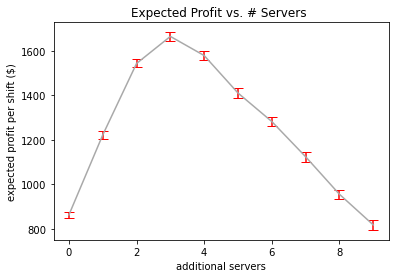

In [4]:
#display results:
optProfit = max(profits)
optAdditionalServers = profits.index(optProfit)

extraServers = [i for i in range(len(profits))]
plt.errorbar(extraServers, profits, yerr =  pErrors, color = "darkgrey", ecolor = "red", elinewidth = 1.5, capsize = 5)
plt.ylabel('expected profit per shift ($)')
plt.xlabel('additional servers')
plt.title("Expected Profit vs. # Servers ")

print("optimal profit estimate:", optProfit)
print("optimal number of additional servers:", optAdditionalServers)

plt.show()

The error bars do not overlap, so we are 95% confident that
the optimal number of extra servers is 3: servers* = [0.8, 0.9, 1, 1, 1]

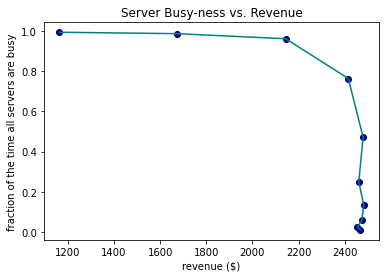

In [5]:
plt.scatter(revenues, busyPercents, color = "navy")
plt.plot(revenues, busyPercents, color = "teal")
plt.ylabel('fraction of the time all servers are busy')
plt.xlabel('revenue ($)')
plt.title("Server Busy-ness vs. Revenue")
plt.show()

The optimal solution ( the point where busy % ~ 0.8 ) occurs when the benefit in added revenue of adding an additional server starts to decline significantly. We can see that when adding only 1 or 2 servers, the added servers are frequently busy, but when we start to add more it is rarer that all of the servers are busy. The optimal solution balances the added revenue from being able to serve more customers with the wasted cost of paying for a server that isn't always working.